# Cluster Photos

This notebook leverages learned features and out-of-the-box clustering techniques to cluster photos with the intent of finding a representative sample.

## Instantiate Encoder

Let's create our encoders and do preliminary work to process our images.

In [1]:
import torch

from photo_encode.encoder import FaissIndexImageEncoder
from transformers import AutoImageProcessor, AutoModel, ViTImageProcessor, ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# First embedding model: dinov2
processor_dino = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
processor_kwargs_dino = {
    "return_tensors" : "pt"
}

dinov2_hf = AutoModel.from_pretrained('facebook/dinov2-large')
dinov2 = FaissIndexImageEncoder(
    dinov2_hf, 
    index_file_out="./data/test_photos_dinov2.db", 
).eval().to(device)
dinov2_concat = FaissIndexImageEncoder(
    dinov2_hf, 
    index_file_out="./data/test_photos_dinov2_concat.db", 
).eval().to(device)

# Second embedding model: ViT
processor_vit = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
processor_kwargs_vit = {
    "return_tensors" : "pt"
}

vit_hf = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
vit = FaissIndexImageEncoder(
    vit_hf, 
    index_file_out="./data/test_photos_vit.db"
).eval().to(device)
vit_concat = FaissIndexImageEncoder(
    dinov2_hf, 
    index_file_out="./data/test_photos_vit_concat.db", 
).eval().to(device)


## Create the Embeddings

Loop over the data with different models and aggregration functions to create our embeddings.

In [2]:
import torch

from tqdm import tqdm

from photo_encode.utils import image_batch_from_folder_generator
from torchvision.transforms import Resize, Compose

# Directory with photos
photo_directory = "./data/test_photos"

# Batch size
batch_size = 4

# Mean aggregation
def mean_aggregate(x):
    embeddings = x.last_hidden_state
    return embeddings.mean(axis=1)

# Concatenation aggregation
def concat_aggregate(x):
    embeddings = x.last_hidden_state
    return embeddings.reshape(embeddings.shape[0], embeddings.shape[1]*embeddings.shape[2])
    
# Walk over the photo directory
with torch.no_grad():
    # For dinov2, we need to override the stack function as the batch collator
    for x, files in tqdm(
        image_batch_from_folder_generator(photo_directory, processor_dino, processor_kwargs_dino, batch_size, collate=lambda x: x)
    ):
        pixel_values = torch.stack(tuple([y["pixel_values"][0] for y in x]))
        dino_batch = {
            "pixel_values" : pixel_values.to(device)
        }
        dinov2_embeddings = dinov2(dino_batch, files, mean_aggregate)
        dinov2_concat_embeddings = dinov2_concat(dino_batch, files, concat_aggregate)


    # For ViT
    for x, files in tqdm(
        image_batch_from_folder_generator(photo_directory, processor_vit, processor_kwargs_vit, batch_size, collate=lambda x: x)
    ):
        pixel_values = torch.stack(tuple([y["pixel_values"][0] for y in x]))
        vit_batch = {
            "pixel_values" : pixel_values.to(device)
        }
        vit_embeddings = vit(vit_batch, files, mean_aggregate)
        vit_concat_embeddings = vit_concat(vit_batch, files, concat_aggregate)



169it [10:00,  3.55s/it]
169it [07:19,  2.60s/it]


## Create Clusters

Loop over a range of cluster numbers and compute metrics for quality.

In [6]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

dinov2_mean_embeddings = dinov2.current_embeddings.detach().cpu().numpy()
dinov2_concat_embeddings = dinov2_concat.current_embeddings.detach().cpu().numpy()
vit_mean_embeddings = vit.current_embeddings.detach().cpu().numpy()
vit_concat_embeddings = vit_concat.current_embeddings.detach().cpu().numpy()


min_clusters = 20
max_clusters = 300
skip = 20
n_init = 1

dinov2_mean_dbs_scores = []
dinov2_mean_ss_scores = []
dinov2_mean_sse_scores = []

dinov2_concat_dbs_scores = []
dinov2_concat_ss_scores = []
dinov2_concat_sse_scores = []

vit_mean_dbs_scores = []
vit_mean_ss_scores = []
vit_mean_sse_scores = []

vit_concat_dbs_scores = []
vit_concat_ss_scores = []
vit_concat_sse_scores = []

# Sum of Squares Error
def sse(
    data: np.array, 
    labels: np.array, 
    centroids: np.array
):
    """
    Compute the sum of squares from data to their
    centroid. Measures tightness of fit.
    """
    sse = {i: 0 for i in np.unique(labels)}
    for d, l, c in zip(data, labels, centroids):
        sse[l] += np.square(d - centroids[l]).sum()

    return np.mean(list(sse.values())), sse
    

# Loop over clusters and embeddings types
for n_c in range(min_clusters, max_clusters + 1, skip):

    """
    DinoV2 with mean aggregation
    """
    print("DinoV2 Mean Aggregation")
    dinov2_mean_kmeans = KMeans(n_clusters=n_c, n_init=n_init)
    dinov2_mean_clusters = dinov2_mean_kmeans.fit_predict(dinov2_mean_embeddings)

    dinov2_mean_cluster_centers = [
        dinov2_mean_embeddings[dinov2_mean_kmeans.labels_ == i].mean(axis=0) for i in range(n_c)
    ]


    
    # TODO: Compute cluster quality metrics
    dinov2_mean_ss = silhouette_score(dinov2_mean_embeddings, dinov2_mean_kmeans.labels_) 
    dinov2_mean_dbs = davies_bouldin_score(dinov2_mean_embeddings, dinov2_mean_kmeans.labels_)
    dinov2_mean_sse,  dinov2_mean_sse_dict = sse(
        dinov2_mean_embeddings,
        dinov2_mean_kmeans.labels_,
        dinov2_mean_cluster_centers
    )
    dinov2_mean_ss_scores += [dinov2_mean_ss]
    dinov2_mean_dbs_scores += [dinov2_mean_dbs]
    dinov2_mean_sse_scores += [dinov2_mean_sse]
    
    print(
        f"n_c: {n_c}\nsilhouette_score: {dinov2_mean_ss}\ndavies_bouldin_score: {dinov2_mean_dbs}\nsse: {dinov2_mean_sse}\n\n"
    )


    dinov2_concat_kmeans = KMeans(n_clusters=n_c, n_init=n_init)
    dinov2_concat_clusters = dinov2_concat_kmeans.fit_predict(dinov2_concat_embeddings)

    dinov2_concat_cluster_centers = [
        dinov2_concat_embeddings[dinov2_concat_kmeans.labels_ == i].mean(axis=0) for i in range(n_c)
    ]

    """
    DinoV2 with Concat Aggregation
    """
    
    # TODO: Compute cluster quality metrics
    dinov2_concat_ss = silhouette_score(dinov2_concat_embeddings, dinov2_concat_kmeans.labels_) 
    dinov2_concat_dbs = davies_bouldin_score(dinov2_concat_embeddings, dinov2_concat_kmeans.labels_)
    dinov2_concat_sse,  dinov2_concat_sse_dict = sse(
        dinov2_concat_embeddings,
        dinov2_concat_kmeans.labels_,
        dinov2_concat_cluster_centers
    )
    dinov2_concat_ss_scores += [dinov2_concat_ss]
    dinov2_concat_dbs_scores += [dinov2_concat_dbs]
    dinov2_concat_sse_scores += [dinov2_concat_sse]
    
    print("DinoV2 Concat Aggregation")
    print(
        f"n_c: {n_c}\nsilhouette_score: {dinov2_concat_ss}\ndavies_bouldin_score: {dinov2_concat_dbs}\nsse: {dinov2_concat_sse}\n\n"
    )
    
    """
    ViT with Mean Aggregation
    """
    
    vit_mean_kmeans = KMeans(n_clusters=n_c, n_init=n_init)
    vit_mean_clusters = vit_mean_kmeans.fit_predict(vit_mean_embeddings)

    vit_mean_cluster_centers = [
        vit_mean_embeddings[vit_mean_kmeans.labels_ == i].mean(axis=0) for i in range(n_c)
    ]


    
    # TODO: Compute cluster quality metrics
    vit_mean_ss = silhouette_score(vit_mean_embeddings, vit_mean_kmeans.labels_) 
    vit_mean_dbs = davies_bouldin_score(vit_mean_embeddings, vit_mean_kmeans.labels_)
    vit_mean_sse,  vit_mean_sse_dict = sse(
        vit_mean_embeddings,
        vit_mean_kmeans.labels_,
        vit_mean_cluster_centers
    )
    vit_mean_ss_scores += [vit_mean_ss]
    vit_mean_dbs_scores += [vit_mean_dbs]
    vit_mean_sse_scores += [vit_mean_sse]
    
    print("ViT Mean Aggregation")
    print(
        f"n_c: {n_c}\nsilhouette_score: {vit_mean_ss}\ndavies_bouldin_score: {vit_mean_dbs}\nsse: {vit_mean_sse}\n\n"
    )
    
    """
    ViT with Concat Aggregation
    """
    
    vit_concat_kmeans = KMeans(n_clusters=n_c, n_init=n_init)
    vit_concat_clusters = vit_concat_kmeans.fit_predict(vit_concat_embeddings)

    vit_concat_cluster_centers = [
        vit_concat_embeddings[vit_concat_kmeans.labels_ == i].mean(axis=0) for i in range(n_c)
    ]


    
    # TODO: Compute cluster quality metrics
    vit_concat_ss = silhouette_score(vit_concat_embeddings, vit_concat_kmeans.labels_) 
    vit_concat_dbs = davies_bouldin_score(vit_concat_embeddings, vit_concat_kmeans.labels_)
    vit_concat_sse,  vit_concat_sse_dict = sse(
        vit_concat_embeddings,
        vit_concat_kmeans.labels_,
        vit_concat_cluster_centers
    )
    vit_concat_ss_scores += [vit_concat_ss]
    vit_concat_dbs_scores += [vit_concat_dbs]
    vit_concat_sse_scores += [vit_concat_sse]

    print("ViT Concat Aggregation")
    print(
        f"n_c: {n_c}\nsilhouette_score: {vit_concat_ss}\ndavies_bouldin_score: {vit_concat_dbs}\nsse: {vit_concat_sse}\n\n"
    )


DinoV2 Mean Aggregation
n_c: 20
silhouette_score: 0.13188442587852478
davies_bouldin_score: 2.0884669083630523
sse: 137.3281005859375


DinoV2 Concat Aggregation
n_c: 20
silhouette_score: 0.030649501830339432
davies_bouldin_score: 4.2007200853167355
sse: 380758.815625


ViT Mean Aggregation
n_c: 20
silhouette_score: 0.0767659842967987
davies_bouldin_score: 2.727417626631885
sse: 8.533668518066406


ViT Concat Aggregation
n_c: 20
silhouette_score: 0.03300807252526283
davies_bouldin_score: 4.135624069166729
sse: 367586.8390625


DinoV2 Mean Aggregation
n_c: 40
silhouette_score: 0.1565997451543808
davies_bouldin_score: 1.830734171370775
sse: 112.56292095184327


DinoV2 Concat Aggregation
n_c: 40
silhouette_score: 0.0390668623149395
davies_bouldin_score: 3.6188124149705203
sse: 350975.655859375


ViT Mean Aggregation
n_c: 40
silhouette_score: 0.11098172515630722
davies_bouldin_score: 2.2751702188627796
sse: 7.620744502544403


ViT Concat Aggregation
n_c: 40
silhouette_score: 0.045698396861

In [7]:
import pandas as pd

cluster_df = pd.DataFrame(
    [
        np.array(range(min_clusters, max_clusters + 1, skip)),
        dinov2_mean_ss_scores,
        dinov2_mean_dbs_scores,
        dinov2_mean_sse_scores,
        dinov2_concat_ss_scores,
        dinov2_concat_dbs_scores,
        dinov2_concat_sse_scores,
        vit_mean_ss_scores,
        vit_mean_dbs_scores,
        vit_mean_sse_scores,
        vit_concat_ss_scores,
        vit_concat_dbs_scores,
        vit_concat_sse_scores,
    ]
)

# Save the experiment above if you want to. Concat runs are time consuming.
cluster_df.to_csv("./data/test_photos_clustering_study.csv")

## Plot Cluster Metrics

By looking at some cluster metrics, let's try to find a good number of clusters to pick to sample our photo space. 

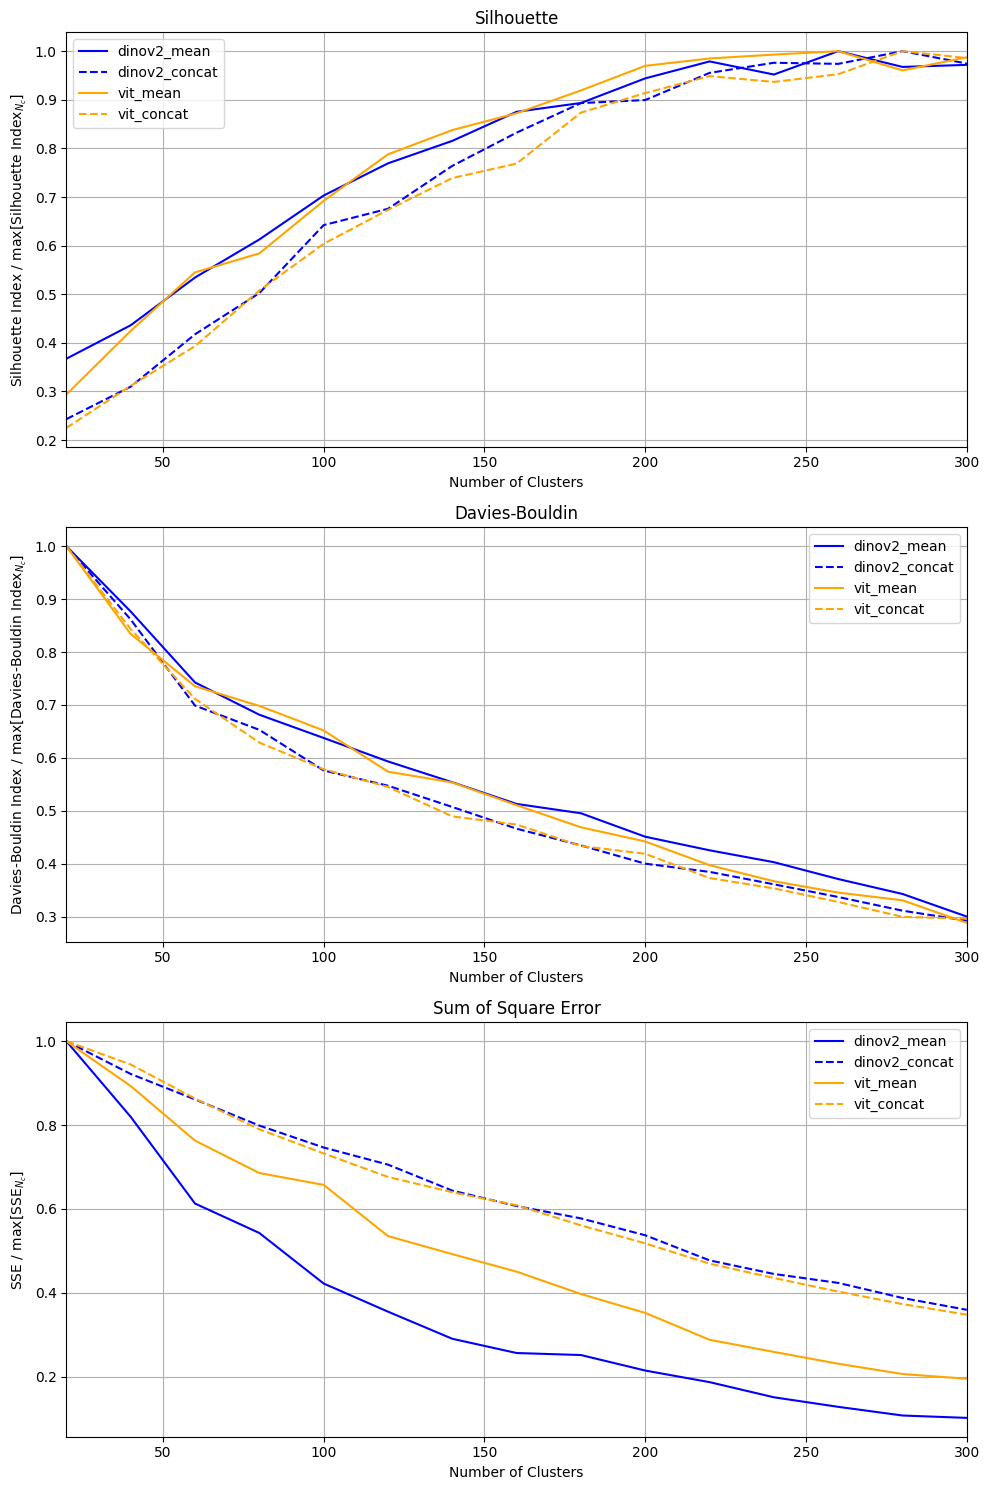

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.array(range(min_clusters, max_clusters + 1, skip))
y = [
    [
        dinov2_mean_ss_scores / np.max(dinov2_mean_ss_scores),
        dinov2_concat_ss_scores / np.max(dinov2_concat_ss_scores),
        vit_mean_ss_scores / np.max(vit_mean_ss_scores),
        vit_concat_ss_scores / np.max(vit_concat_ss_scores),
    ],
    [
        dinov2_mean_dbs_scores / np.max(dinov2_mean_dbs_scores),
        dinov2_concat_dbs_scores / np.max(dinov2_concat_dbs_scores),
        vit_mean_dbs_scores / np.max(vit_mean_dbs_scores),
        vit_concat_dbs_scores / np.max(vit_concat_dbs_scores),
    ],
    [
        dinov2_mean_sse_scores / np.max(dinov2_mean_sse_scores),
        dinov2_concat_sse_scores / np.max(dinov2_concat_sse_scores),
        vit_mean_sse_scores / np.max(vit_mean_sse_scores),
        vit_concat_sse_scores / np.max(vit_concat_sse_scores)
    ]
]

labels = [
    'dinov2_mean', 'dinov2_concat', 'vit_mean', 'vit_concat'
]

colors = [
    "blue", "blue", "orange", "orange"
]

lss = [
    "-", "--", "-", "--"
]

y_labels = [
    r"$\text{Silhouette Index / max}[\text{Silhouette Index}_{N_c}]$",
    r"$\text{Davies-Bouldin Index / max}[\text{Davies-Bouldin Index}_{N_c}]$",
    r"$\text{SSE / max}[\text{SSE}_{N_c}]$"
]

# Create a figure and a grid of subplots (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Titles for the subplots
titles = ['Silhouette', 'Davies-Bouldin', 'Sum of Square Error']

# Loop through each subplot
for i, (ax, title, y_label) in enumerate(zip(axes, titles, y_labels)):
    for y_i, label, ls, c in zip(y[i], labels, lss, colors):
        ax.plot(x, y_i, label=label, c=c, ls=ls)
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(y_label)
    ax.set_xlim(min_clusters, max_clusters)
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## Select a Random Sample of Photos from the Best Performer

Now that we have a general idea of how each method partitions the space, let's look at a few informative samples from the top clusters from the best performing algorithm.

In [16]:
import numpy as np

from typing import List

# Set seed so we can reproduce result
np.random.seed(1)

def select_sample(
    files: List[str],
    labels: np.ndarray,
    n_per_index: int = 1
):
    file_sample = []
    file_array = np.array(files)
    for c in np.unique(labels):
        sample = np.random.choice(file_array[labels == c], replace=False)
        file_sample += sample.tolist()
    return file_sample

dinov2_mean_cluster_count = 150
dinov2_mean_kmeans_best = KMeans(n_clusters=n_c, n_init=10)
dinov2_mean_clusters_best = dinov2_mean_kmeans_best.fit_predict(dinov2_mean_embeddings)